In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import sys
sys.path.insert(1, 'scripts/')
from gen_matrix import matrix_gen, get_ICA
from get_sample import get_sample, create_strings_for_dataset
from fft import fft_for_sample
from tqdm import tqdm
import collections
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
import operator

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def generate_simple_dataset(linspace, chanals, pandas=False):
    p1,p2,p3 = linspace
    v = np.linspace(p1, p2, p3)
    
    dataset = v
    for i in range(chanals-1):
        dataset = np.vstack((dataset, v))
        
    if pandas:
        return pd.DataFrame(dataset)
    
    return dataset

def func_for_1class(t, noise=0.5):
    return 2*np.cos(5*2*pi*t) + 5*np.cos(15*2*pi*t) + 3*np.cos(20*2*pi*t) + np.random.normal(0,1)

def func_for_2class(t, noise=0.5):
    return 3*np.cos(5*2*pi*t) + 2*np.cos(15*2*pi*t) + 3*np.cos(20*2*pi*t) + np.random.normal(0,1)

def func_for_3class(t, noise=0.5):
    return 4*np.cos(5*2*pi*t) + 10*np.cos(15*2*pi*t) + 3*np.cos(20*2*pi*t) + np.random.normal(0,1)

def func_general(t, noise=0.5):
    return 9*np.cos(5*2*pi*t) + 10*np.cos(15*2*pi*t) + 3*np.cos(20*2*pi*t) + np.random.normal(0,1)

def get_cosinus_matrix(chanals, linspace):
    data_simple = generate_simple_dataset(linspace, chanals)
    vec = data_simple[0]
    
    size = (chanals, linspace[2])
    class_ = size[1]//3
    class1 = [0,class_]
    class2 = [class_,class_*2]
    class3 = [class_*2, data_simple.shape[1]]
    
    
    vec[class1[0]:class1[1]] = func_for_1class(vec[class1[0]:class1[1]])
    vec[class2[0]:class2[1]] = func_for_2class(vec[class2[0]:class2[1]])
    vec[class3[0]:class3[1]] = func_for_3class(vec[class3[0]:class3[1]])
    

    data_simple = func_general(data_simple)
    data_simple[0] = data_simple[1]
    
    data_simple[65] = vec
    data_simple[10] = vec
    data_simple[100] = vec
    #data_simple[60] = vec
    #data_simple[61] = vec
    #data_simple[20] = vec

    
    return data_simple

In [6]:
CHANALS = 128
LINSPACE = 0, 200, 20000
N_COMPONENTS_PCA = 60

matrix = get_cosinus_matrix(chanals=CHANALS, linspace=LINSPACE)
size = matrix.shape
class_ = size[1]//3

In [7]:
class_

6666

In [8]:
matrix.shape

(128, 20000)

In [9]:
(matrix[65][::2][::2][::2])

array([ 9.38253581, -3.1185181 , -3.12206992, ..., -9.25461261,
        3.32769705,  5.06404685])

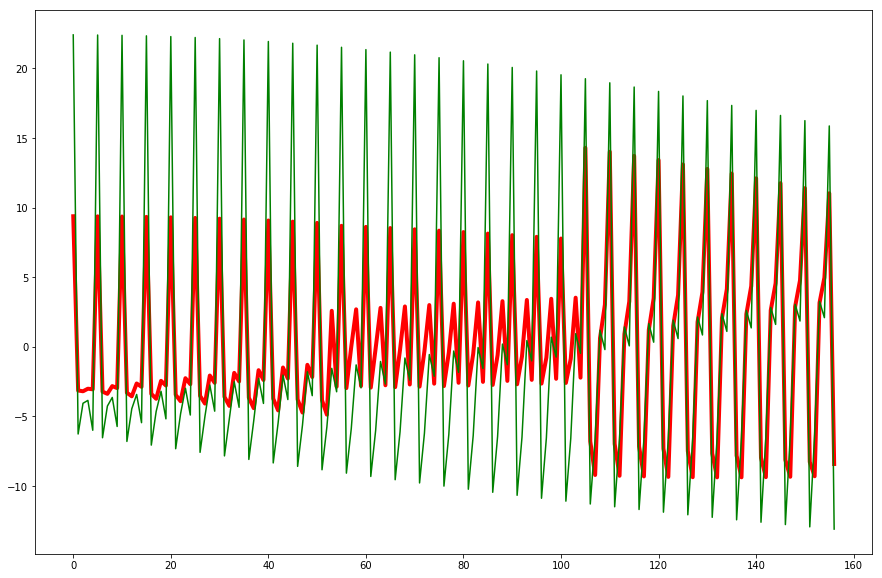

In [10]:
plt.figure(figsize=(15,10))
plt.plot(matrix[65][::2][::2][::2][::2][::2][::2][::2], c='r', linewidth=4.0)
plt.plot(matrix[0][::2][::2][::2][::2][::2][::2][::2], c='g')

plt.show()

In [11]:
from sklearn.decomposition import FastICA

FastICA = FastICA(n_components=128).fit(matrix.T)
ICA = FastICA.transform(matrix.T)


In [12]:
FastICA.mixing_.shape

(128, 128)

In [13]:
matrix = ICA.T

In [14]:
# CHANALS = 100
# size = matrix.shape

In [15]:
matrix.shape

(128, 20000)

In [16]:
class_

6666

In [17]:
matrix_class1 = matrix[:,0:class_]
matrix_calss2 = matrix[:, class_:class_*2]
matrix_calss3 = matrix[:, class_*2:matrix.shape[1]]
#Получаем семплы для каждого класса
sample_calss1 = get_sample(matrix_class1, sample_size=300, step=100)
sample_calss2 = get_sample(matrix_calss2, sample_size=300, step=100)
sample_calss3 = get_sample(matrix_calss3, sample_size=300, step=100)


In [18]:
len(sample_calss1)

67

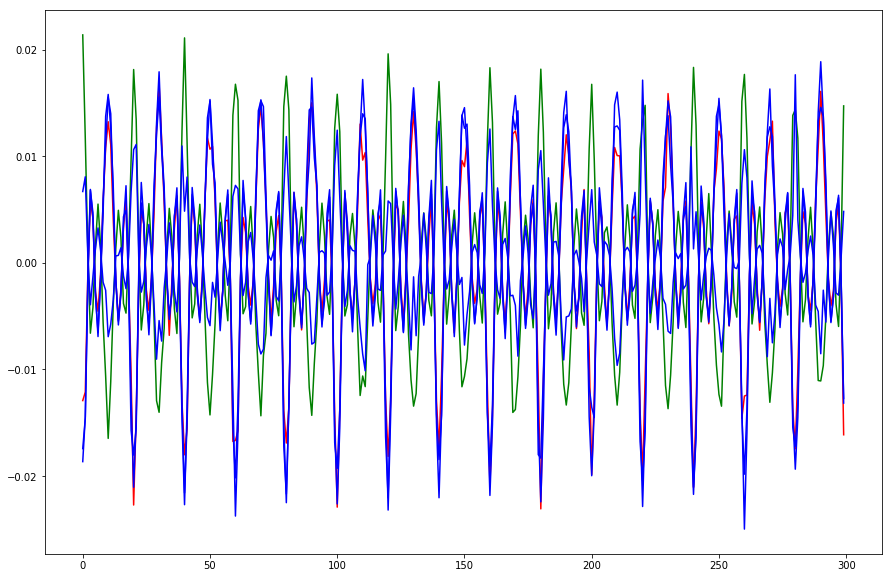

In [19]:
plt.figure(figsize=(15,10))
plt.plot(sample_calss1[0][100], c='r')
plt.plot(sample_calss1[0][10], c='g')
plt.plot(sample_calss1[0][2], c='b')
plt.plot(sample_calss1[0][1], c='b')
plt.plot(sample_calss1[0][3], c='b')

plt.show()

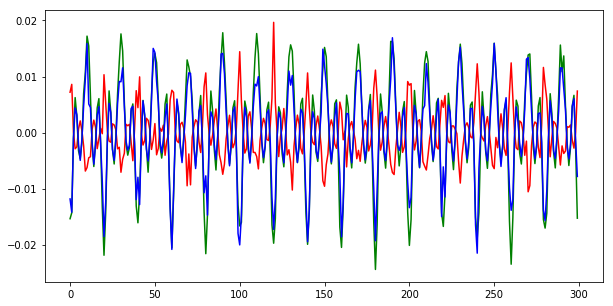

In [20]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1[10][2], c='r')
plt.plot(sample_calss1[10][3], c='g')
plt.plot(sample_calss1[10][4], c='b')
plt.show()

In [21]:
i_ = 0
for i in range(len(sample_calss1)):
    for j in range(sample_calss1[0].shape[0]):
        #print(sample_calss1[i][j].shape[0])
        if sample_calss1[i][j].shape[0] != 300:
            if i_ == 0:
                i_ = i

In [22]:
sample_calss1 = sample_calss1[:i_]
sample_calss2 = sample_calss2[:i_]
sample_calss3 = sample_calss3[:i_]

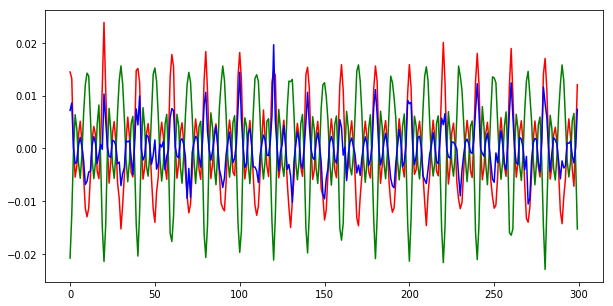

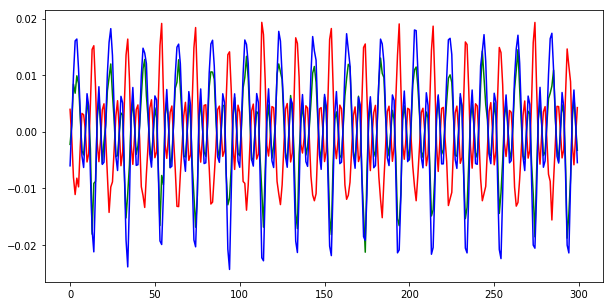

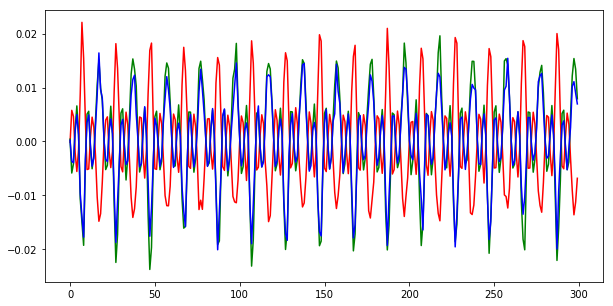

In [23]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1[10][10], c='r')
plt.plot(sample_calss1[10][1], c='g')
plt.plot(sample_calss1[10][2], c='b')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss2[10][10], c='r')
plt.plot(sample_calss2[10][4], c='g')
plt.plot(sample_calss2[10][0], c='b')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss3[10][10], c='r')
plt.plot(sample_calss3[10][3], c='g')
plt.plot(sample_calss3[10][4], c='b')
plt.show()

In [24]:
samples_fft = list(fft_for_sample(sample_calss1 + sample_calss2 + sample_calss3, freq=100))


In [25]:
len_class = len(sample_calss1)
sample_calss1_fft = samples_fft[:len_class]
sample_calss2_fft = samples_fft[len_class:len_class*2]
sample_calss3_fft = samples_fft[len_class*2:]

In [26]:
FIRST_N_FFT = len(sample_calss1_fft[0][0])

In [27]:
FIRST_N_FFT

174

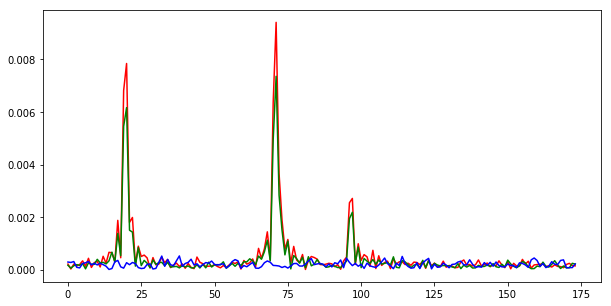

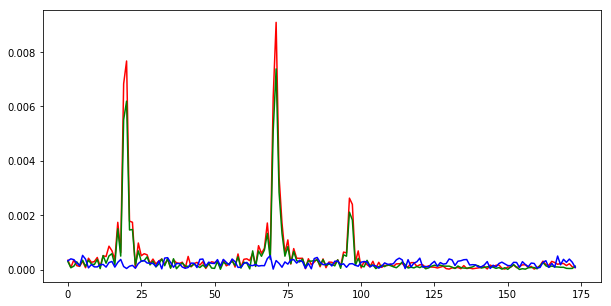

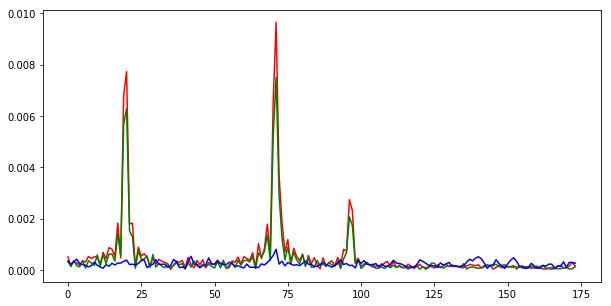

In [28]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1_fft[10][65], c='r')
plt.plot(sample_calss1_fft[10][64], c='g')
plt.plot(sample_calss1_fft[10][63], c='b')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss2_fft[10][65], c='r')
plt.plot(sample_calss2_fft[10][64], c='g')
plt.plot(sample_calss2_fft[10][63], c='b')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss3_fft[10][65], c='r')
plt.plot(sample_calss3_fft[10][64], c='g')
plt.plot(sample_calss3_fft[10][63], c='b')
plt.show()

In [29]:
for i in range(len(sample_calss1_fft)):
    for j in range(sample_calss1_fft[0].shape[0]):
        sh = sample_calss1_fft[i][j].shape[0]
        if sh != FIRST_N_FFT:
            print(sh)

In [30]:
#Создание строк для датасета, из матрицы 128*174 -> в вектор 22272
sample_calss1_fft_str = create_strings_for_dataset(sample_calss1_fft)
sample_calss2_fft_str = create_strings_for_dataset(sample_calss2_fft)
sample_calss3_fft_str = create_strings_for_dataset(sample_calss3_fft)

In [31]:
(sample_calss1_fft[0].shape)

(128, 174)

In [32]:
def values_65(samples_fft):
    strings = []
    for i in range(len(samples_fft)):
        new_string = []
        for n in range(samples_fft[i].shape[1]):
            new_string.append(samples_fft[i][65,n])
        strings.append(new_string)

    return strings


In [33]:
def index_65(sample_calss_fft_str, sample_calss_fft_str_65):
    indexes = []
    for i in range(len(sample_calss1_fft_str)):
        index = []
        for j in range(len(sample_calss_fft_str_65[i])):
            index.append(sample_calss_fft_str[i].index(sample_calss_fft_str_65[i][j]))
        indexes.append(index)
    return indexes

In [34]:
sample_calss_1_fft_str_65 = values_65(sample_calss1_fft)
sample_calss_2_fft_str_65 = values_65(sample_calss2_fft)
sample_calss_3_fft_str_65 = values_65(sample_calss3_fft)


sample_calss_1_fft_str_65_index = index_65(sample_calss1_fft_str, sample_calss_1_fft_str_65)
sample_calss_2_fft_str_65_index = index_65(sample_calss2_fft_str, sample_calss_2_fft_str_65)
sample_calss_3_fft_str_65_index = index_65(sample_calss3_fft_str, sample_calss_3_fft_str_65)
    


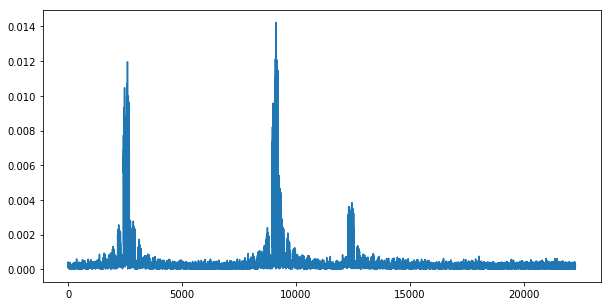

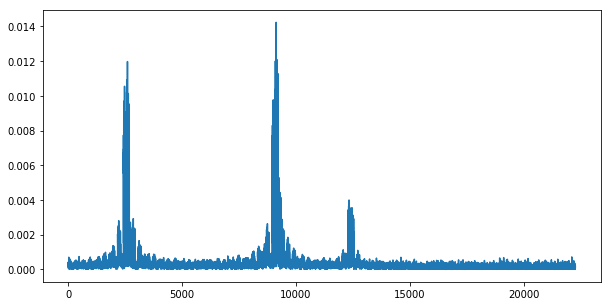

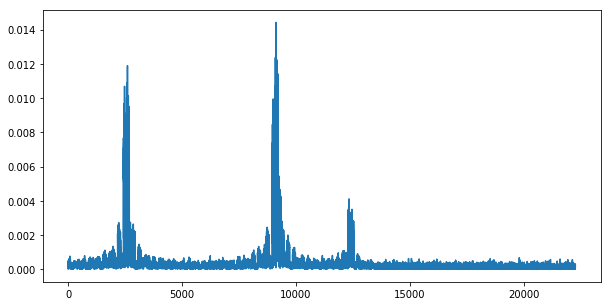

In [35]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1_fft_str[0])
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss2_fft_str[0])
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss3_fft_str[0])
plt.show()

In [36]:
size[0]

128

In [37]:
#Создание таблицы объекты-признаки

#Класс 1
data_class_1 = pd.DataFrame(data=np.zeros((len_class, size[0] * 174)))
data_class_1['label'] = 1

data_class_1 = np.array(data_class_1)

for i in tqdm(range(len(sample_calss1_fft_str))):
    data_class_1[i, :-1] = sample_calss1_fft_str[i]
    
    
#Класс 2
data_class_2 = pd.DataFrame(data=np.zeros((len_class, size[0] * 174)))
data_class_2['label'] = 2

data_class_2 = np.array(data_class_2)

for i in tqdm(range(len(sample_calss2_fft_str))):
    data_class_2[i, :-1] = sample_calss2_fft_str[i]
    
    
#Класс 3
data_class_3 = pd.DataFrame(data=np.zeros((len_class, size[0] * 174)))
data_class_3['label'] = 3

data_class_3 = np.array(data_class_3)

for i in tqdm(range(len(sample_calss3_fft_str))):
    data_class_3[i, :-1] = sample_calss3_fft_str[i]
    

    

data = np.vstack([data_class_1, data_class_2, data_class_3])
data = pd.DataFrame(data)
print(data.shape)

100%|██████████| 64/64 [00:00<00:00, 793.22it/s]


(192, 22273)


In [38]:
data.columns = [*data.columns[:-1], 'label']

In [39]:
def scoring_fi(feature_importances):
    above_zero = feature_importances['importance'][:np.sum(feature_importances['importance'] > 0)]
    mean_value = above_zero.mean()
    features_good = above_zero[above_zero > mean_value].index.tolist()
    features_normal = above_zero[above_zero <= mean_value].index.tolist()
    features_bad = [i for i in feature_importances.index.tolist() if i not in features_good and
                    i not in features_normal]
    
    
    features_good = [i for i in features_good if i not in ['[', ']', ',']]
    features_normal = [i for i in features_normal if i not in ['[', ']', ',']]
    features_bad = [i for i in features_bad if i not in ['[', ']', ',']]
    
    features_good = list(map(lambda x: str(x), features_good))
    features_normal = list(map(lambda x: str(x), features_normal))
    features_bad = list(map(lambda x: str(x), features_bad))
    
    
    return features_good, features_normal, features_bad

In [40]:
'''
{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}
'''

"\n{'bootstrap': True,\n 'max_depth': 10,\n 'max_features': 'auto',\n 'min_samples_leaf': 1,\n 'min_samples_split': 2,\n 'n_estimators': 200}\n"

In [41]:

# ###SOLO

# ## Понизим размерность до 60 компонент
# from sklearn.decomposition import PCA
# PCA = PCA(n_components=N_COMPONENTS_PCA, random_state=100)
# #Стандартизируем матрицу
# # Scaler = StandardScaler()
# # data_standart = Scaler.fit_transform((data).iloc[:, :-1])
# data_standart = (data).iloc[:, :-1]
# # Понижаем размерность
# data_pca = PCA.fit_transform(data_standart)
# data_pca = pd.DataFrame(data_pca)

# # data_pca['label'] = data['label'].values
# labels = data['label'].values

# #Посмотрим важные признаки с помощью RF
# # rf = RandomForestClassifier(bootstrap=True, max_depth=10,
# #                            max_features='auto', min_samples_leaf=1,
# #                            min_samples_split=2, n_estimators=200)
# rf = RandomForestClassifier(n_estimators=10000)
# rf.fit(data_pca, labels)

# feature_importances = pd.DataFrame(rf.feature_importances_,
#                                index = data_pca.columns,
#                                 columns=['importance']).sort_values('importance',ascending=False)

# features_good, features_normal, features_bad = scoring_fi(feature_importances)

In [42]:

### ANSAMBEL


## Понизим размерность до 60 компонент
from sklearn.decomposition import PCA
PCA = PCA(n_components=N_COMPONENTS_PCA, random_state=100)
#Стандартизируем матрицу
# Scaler = StandardScaler()
# data_standart = Scaler.fit_transform((data).iloc[:, :-1])
data_standart = (data).iloc[:, :-1]

# Понижаем размерность
data_pca = PCA.fit_transform(data_standart)
data_pca = pd.DataFrame(data_pca)

# data_pca['label'] = data['label'].values
labels = data['label'].values


fg = []
fn = []
fb = []
for _ in range(200):
    rf = RandomForestClassifier()
    rf.fit(data_pca, labels)
    feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = data_pca.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
    
    features_good, features_normal, features_bad = scoring_fi(feature_importances)
    fg.extend(features_good)
    fn.extend(features_normal)
    fb.extend(features_bad)

features_good = list(map(lambda x: x[0], sorted(collections.Counter(fg).items(), key=operator.itemgetter(1), reverse=True)[:10]))
features_normal = list(map(lambda x: x[0],
                           sorted(collections.Counter(fn).items(), key=operator.itemgetter(1), reverse=True)))

features_normal = list(set(features_normal) - set(features_good))

features_bad = list(set(fb) - set(features_good) - set(features_normal))

In [43]:
data_pca.shape

(192, 60)

In [44]:
# from sklearn.model_selection import cross_val_score

# rf = RandomForestClassifier()
# cv_score = [np.mean(cross_val_score(rf, data_pca, labels)) for _ in range(300)]


# plt.figure(figsize=(12,6))
# plt.scatter(range(1, 301), cv_score, c='b')
# plt.ylabel('accuracy score')
# plt.xlabel('n cross validation')
# plt.show()

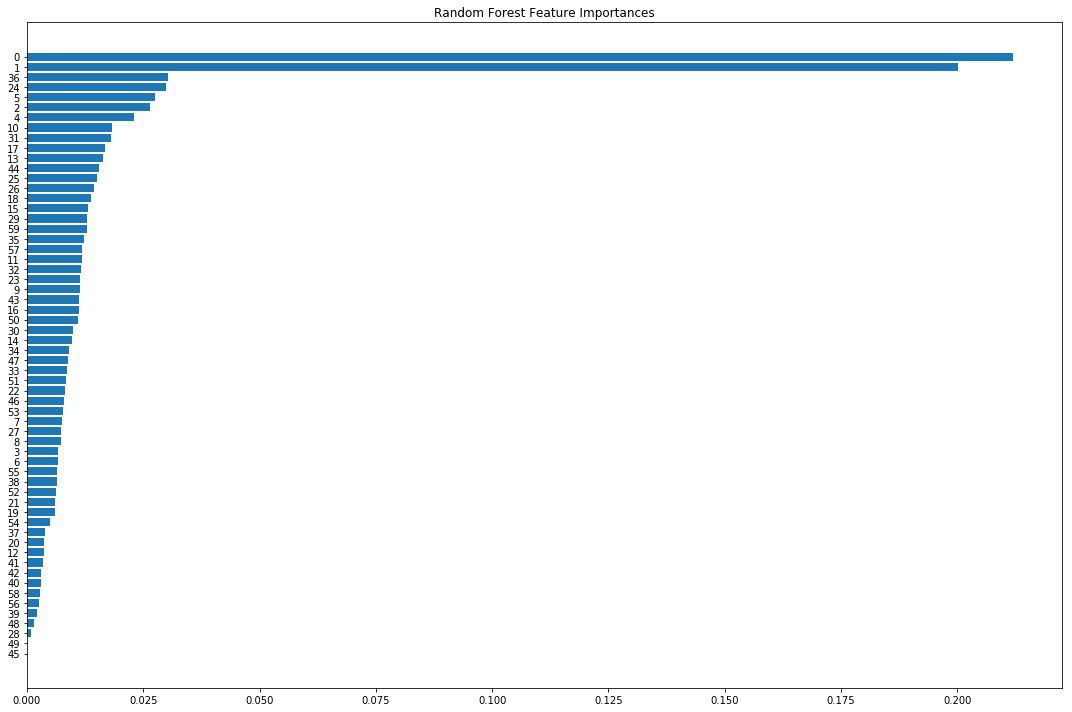

In [45]:
tree_feature_importances = (rf.feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(data_pca.columns))
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(data_pca.columns[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances")
fig.tight_layout()
plt.savefig('RF PCA Feature Importances')
plt.show()

In [46]:
# feature_importances = pd.DataFrame(rf.feature_importances_,
#                                    index = data_pca.columns,
#                                     columns=['importance']).sort_values('importance',ascending=False)

In [47]:
train_features = data_standart
from sklearn.decomposition import PCA
model = PCA(n_components=N_COMPONENTS_PCA, random_state=100).fit(train_features)
X_pc = model.transform(train_features)

#features_good, features_normal, features_bad = scoring_fi(feature_importances)

In [48]:
def features_imp_pca(train_features, model_pca, X_pca, features_good, features_bad, features_normal):
    
    global size, N_COMPONENTS_PCA, FIRST_N_FFT
    
    reward_best = 50
    reward_max = 10
    reward_med = 5
    reward_min = 1
    
    fe_imp = {}
    for feature in range(0, size[1]):
        fe_imp['feature' + '_' + str(feature)] = 0
        
    component_max_list = [abs(pd.DataFrame(model_pca.components_).loc[i, :]).max() for i in range(N_COMPONENTS_PCA)]
    component_mean_list = [abs(pd.DataFrame(model_pca.components_).loc[i, :]).mean() for i in range(N_COMPONENTS_PCA)]
        
    for feature in tqdm(range(0, size[0]*FIRST_N_FFT)):
        reward = 0
        for component in range(0, N_COMPONENTS_PCA):
            feature_value =abs( model_pca.components_[component, feature])
            component_max = component_max_list[component]
            component_mean = component_mean_list[component]
            
            comparison_max = component_max - component_max / 10
            comparison_med = component_max - component_max / 20
            comparison_min = component_mean
            
            
            
            if feature_value >= comparison_min:
                if str(component) in features_bad:
                    reward -= reward_min
                elif str(feature) in features_good or str(feature) in features_normal:
                    reward += reward_min
            
            if feature_value >= comparison_med:
                if str(component) in features_bad:
                    reward -= reward_med
                elif str(component) in features_normal:
                    reward += reward_med
                elif str(component) in features_good:
                    reward += reward_max
            
            if feature_value >= comparison_max:
                if str(component) in features_bad:
                    reward -= reward_max
                elif str(component) in features_normal:
                    reward += reward_max
                elif str(component) in features_good:
                    reward += reward_best #best
                    
            if feature_value <= comparison_min:
                if str(component) in features_bad:
                    reward += reward_min
                elif str(component) in features_good or str(feature) in features_normal:
                    reward -= reward_min
                    
                    
        fe_imp['feature' + '_' + str(feature)] = reward
            
    return fe_imp
            
            
    
    
    

In [49]:
d = features_imp_pca((train_features), model, X_pc, features_good, features_bad, features_normal)

100%|██████████| 22272/22272 [00:02<00:00, 7665.97it/s]


In [50]:
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
best_features = [sorted_d[i][0] for i in range(15)]

In [51]:
sorted_d[:15]

[('feature_2680', 88),
 ('feature_2664', 84),
 ('feature_2619', 77),
 ('feature_2621', 74),
 ('feature_12347', 73),
 ('feature_9149', 72),
 ('feature_9213', 72),
 ('feature_9180', 69),
 ('feature_2650', 68),
 ('feature_12213', 65),
 ('feature_2536', 63),
 ('feature_9187', 60),
 ('feature_9108', 59),
 ('feature_9192', 59),
 ('feature_9208', 59)]

In [52]:
sorted_d[-15:]

[('feature_18', -22),
 ('feature_5', -24),
 ('feature_29', -24),
 ('feature_9', -28),
 ('feature_40', -28),
 ('feature_42', -28),
 ('feature_13', -32),
 ('feature_31', -32),
 ('feature_54', -32),
 ('feature_46', -34),
 ('feature_16', -36),
 ('feature_7', -38),
 ('feature_15', -38),
 ('feature_8', -46),
 ('feature_20', -58)]

In [53]:
### Главные признаки, с которыми будем рабоать 
train_features = pd.DataFrame(train_features)
for number_feature in list(best_features):
    number_feature = int(number_feature.split('_')[1])
    train_features.iloc[:, number_feature] = train_features.iloc[:, number_feature].apply(lambda x: str(x) +
                                                                                          '_FE').values

# train_features.iloc[:, 1669] = train_features.iloc[:, 1669].apply(lambda x: str(x) + '_FE').values

In [54]:
### Восстановим исходный вид таблицы, а именно 128x20x100 (102 в данном примере)

old_table = []
for i in tqdm(range(train_features.shape[0])):
    sample = pd.DataFrame(np.zeros((CHANALS, 174)))
    string = train_features.iloc[i, :]
    
    index_start = 0
    index_end = CHANALS

        
    for s in range(174): ##!!!
        sample.iloc[:, s] = string.iloc[index_start : index_end].values
        index_start = index_end
        index_end += CHANALS

        if index_end > size[0]*174:
            break

    old_table.append(sample.values)
  

100%|██████████| 192/192 [00:30<00:00,  6.24it/s]


In [55]:
### Найдем в исходной таблице важный признак

FE_items = []


for table_number, table in tqdm(enumerate(old_table)):
    for column in range(table.shape[1]):
        for idx in range(table.shape[0]):
            if len(str(table[idx, column]).split('_')) > 1:
                FE_items.append((table_number, idx, column))
            
            

192it [00:04, 41.80it/s]


In [56]:
FE_items

[(0, 104, 19),
 (0, 59, 20),
 (0, 61, 20),
 (0, 90, 20),
 (0, 104, 20),
 (0, 120, 20),
 (0, 20, 71),
 (0, 61, 71),
 (0, 92, 71),
 (0, 99, 71),
 (0, 104, 71),
 (0, 120, 71),
 (0, 125, 71),
 (0, 53, 95),
 (0, 59, 96),
 (1, 104, 19),
 (1, 59, 20),
 (1, 61, 20),
 (1, 90, 20),
 (1, 104, 20),
 (1, 120, 20),
 (1, 20, 71),
 (1, 61, 71),
 (1, 92, 71),
 (1, 99, 71),
 (1, 104, 71),
 (1, 120, 71),
 (1, 125, 71),
 (1, 53, 95),
 (1, 59, 96),
 (2, 104, 19),
 (2, 59, 20),
 (2, 61, 20),
 (2, 90, 20),
 (2, 104, 20),
 (2, 120, 20),
 (2, 20, 71),
 (2, 61, 71),
 (2, 92, 71),
 (2, 99, 71),
 (2, 104, 71),
 (2, 120, 71),
 (2, 125, 71),
 (2, 53, 95),
 (2, 59, 96),
 (3, 104, 19),
 (3, 59, 20),
 (3, 61, 20),
 (3, 90, 20),
 (3, 104, 20),
 (3, 120, 20),
 (3, 20, 71),
 (3, 61, 71),
 (3, 92, 71),
 (3, 99, 71),
 (3, 104, 71),
 (3, 120, 71),
 (3, 125, 71),
 (3, 53, 95),
 (3, 59, 96),
 (4, 104, 19),
 (4, 59, 20),
 (4, 61, 20),
 (4, 90, 20),
 (4, 104, 20),
 (4, 120, 20),
 (4, 20, 71),
 (4, 61, 71),
 (4, 92, 71),
 (4, 99

In [57]:
best_feat = list(map(lambda x: x[0], 
    sorted(collections.Counter(list(map(lambda x: x[1], FE_items))).items(), 
           key=operator.itemgetter(1), reverse=True)))

____

In [58]:
for i in best_feat:
    print(np.argmax(np.abs(FastICA.mixing_[:, i])))

65
10
65
65
100
10
10
100
65
10


In [59]:
FastICA.mixing_.shape

(128, 128)